# _Trial 25: 50/50 Resample Dataset_

# _Set Up_

__July 9, 2019__

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [3]:
from fastai.vision import *
from torchvision.models import *
import yaml
import datetime

from sklearn.metrics import roc_auc_score

In [4]:
path = Config.data_path()
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

# _Load in Data_

In [5]:
# read in csv files for training and validation sets
train_df = pd.read_csv(path/'CheXpert-v1.0-small/train.csv')
valid_df = pd.read_csv(path/'CheXpert-v1.0-small/valid.csv')

# _Edit Data Sets_

In [6]:
train_df['valid'] = False
valid_df['valid'] = True

In [7]:
# create patient and study column for train and valid df
train_df['patient'] = train_df.Path.str.split('/',3,True)[2]
train_df['study'] = train_df.Path.str.split('/',4,True)[3]

valid_df['patient'] = valid_df.Path.str.split('/',3,True)[2]
valid_df['study'] = valid_df.Path.str.split('/',4,True)[3]

In [8]:
pathology_list = list(train_df.columns[5:19])
pathology_list

['No Finding',
 'Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture',
 'Support Devices']

In [9]:
train_df[pathology_list] = train_df[pathology_list].fillna(0)
train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,valid,patient,study
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,patient00001,study1
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0,False,patient00002,study2
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,patient00002,study1
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,patient00002,study1
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,patient00003,study1


In [10]:
train_df.isnull().sum()

Path                              0
Sex                               0
Age                               0
Frontal/Lateral                   0
AP/PA                         32387
No Finding                        0
Enlarged Cardiomediastinum        0
Cardiomegaly                      0
Lung Opacity                      0
Lung Lesion                       0
Edema                             0
Consolidation                     0
Pneumonia                         0
Atelectasis                       0
Pneumothorax                      0
Pleural Effusion                  0
Pleural Other                     0
Fracture                          0
Support Devices                   0
valid                             0
patient                           0
study                             0
dtype: int64

In [11]:
from test_folder import replicate

train_df = replicate.uignore(train_df, 'Cardiomegaly')
train_df.head()

Dropped -1 observations.
------------------------------
Converted pathology column into integer type.
------------------------------
Shape of new dataframe: (215327, 22)


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,valid,patient,study
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,patient00001,study1
1,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,0.0,0.0,0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,patient00002,study1
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,0.0,0.0,0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,patient00002,study1
3,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,patient00003,study1
4,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,PA,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,patient00004,study1


In [12]:
train_df['Cardiomegaly'].value_counts()

0    188327
1     27000
Name: Cardiomegaly, dtype: int64

# _Randomly Undersample Negative Observations for Cardiomegaly_

In [13]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [14]:
set_seed(1)

In [15]:
# Class count
count_class_0, count_class_1 = train_df['Cardiomegaly'].value_counts()
print(count_class_0, count_class_1)

188327 27000


In [16]:
# Divide by class
df_class_0 = train_df[train_df['Cardiomegaly'] == 0]
df_class_1 = train_df[train_df['Cardiomegaly'] == 1]

In [17]:
print(df_class_0.shape)
print(df_class_1.shape)

(188327, 22)
(27000, 22)


In [18]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under['Cardiomegaly'].value_counts())

Random under-sampling:
1    27000
0    27000
Name: Cardiomegaly, dtype: int64


In [19]:
df_test_under.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,valid,patient,study
178863,CheXpert-v1.0-small/train/patient44030/study3/...,Male,90,Frontal,AP,0.0,0.0,0,1.0,0.0,0.0,-1.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,False,patient44030,study3
160519,CheXpert-v1.0-small/train/patient38879/study4/...,Male,65,Frontal,AP,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,False,patient38879,study4
144880,CheXpert-v1.0-small/train/patient35621/study3/...,Male,83,Frontal,AP,0.0,0.0,0,1.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,False,patient35621,study3
100110,CheXpert-v1.0-small/train/patient25012/study2/...,Male,44,Frontal,AP,0.0,0.0,0,1.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,False,patient25012,study2
92967,CheXpert-v1.0-small/train/patient23250/study2/...,Male,77,Frontal,AP,0.0,0.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,False,patient23250,study2


In [20]:
df_test_under_shuffled = df_test_under.sample(frac=1).reset_index(drop=True)

In [21]:
df_test_under_shuffled.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,valid,patient,study
0,CheXpert-v1.0-small/train/patient02395/study2/...,Female,73,Frontal,AP,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,False,patient02395,study2
1,CheXpert-v1.0-small/train/patient45206/study7/...,Male,46,Frontal,AP,0.0,0.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,False,patient45206,study7
2,CheXpert-v1.0-small/train/patient15886/study2/...,Female,64,Frontal,AP,0.0,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,patient15886,study2
3,CheXpert-v1.0-small/train/patient18653/study1/...,Male,65,Frontal,AP,0.0,1.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,False,patient18653,study1
4,CheXpert-v1.0-small/train/patient27473/study2/...,Male,89,Frontal,AP,0.0,0.0,1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,False,patient27473,study2


In [22]:
valid_df['Cardiomegaly'] = valid_df['Cardiomegaly'].astype(int)

In [23]:
valid_df['Cardiomegaly'].value_counts()

0    166
1     68
Name: Cardiomegaly, dtype: int64

In [24]:
# concat undersampled train_df and valid_df together
full_df = pd.concat([df_test_under_shuffled, valid_df])

In [25]:
full_df.shape

(54234, 22)

In [26]:
full_df.head(20)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,valid,patient,study
0,CheXpert-v1.0-small/train/patient02395/study2/...,Female,73,Frontal,AP,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,False,patient02395,study2
1,CheXpert-v1.0-small/train/patient45206/study7/...,Male,46,Frontal,AP,0.0,0.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,False,patient45206,study7
2,CheXpert-v1.0-small/train/patient15886/study2/...,Female,64,Frontal,AP,0.0,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,patient15886,study2
3,CheXpert-v1.0-small/train/patient18653/study1/...,Male,65,Frontal,AP,0.0,1.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,False,patient18653,study1
4,CheXpert-v1.0-small/train/patient27473/study2/...,Male,89,Frontal,AP,0.0,0.0,1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,False,patient27473,study2
5,CheXpert-v1.0-small/train/patient07981/study1/...,Male,55,Lateral,NaN,0.0,0.0,0,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,False,patient07981,study1
6,CheXpert-v1.0-small/train/patient22665/study23...,Male,50,Frontal,AP,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,False,patient22665,study23
7,CheXpert-v1.0-small/train/patient23369/study2/...,Male,58,Frontal,PA,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,patient23369,study2
8,CheXpert-v1.0-small/train/patient27355/study2/...,Male,69,Lateral,NaN,0.0,0.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,False,patient27355,study2
9,CheXpert-v1.0-small/train/patient31100/study7/...,Female,75,Frontal,AP,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,False,patient31100,study7


# _Deep Learning Fast.AI Set Up_

In [27]:
from test_folder import replicate

src = replicate.get_src(full_df, path, feature_col='Cardiomegaly')

In [28]:
data = replicate.get_data(64, src)

using bs=16, have 7601MB of GPU RAM free.
------------------------------
Data ready.


# _Deep Learning Baseline Model Set Up_

In [29]:
learn = cnn_learner(data=data, base_arch=models.resnet152, metrics=[AUROC(), Precision()], 
                    pretrained=True)

# _First Round of Training for Baseline Model_

In [30]:
from fastai.callbacks import EarlyStoppingCallback
# train model with early stopping in case model performance doesn't continue improving
learn.fit_one_cycle(5, callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,auroc,precision,time
0,0.687138,0.629927,0.730510,0.507937,09:05
1,0.577818,0.549448,0.736446,0.500000,09:11
2,0.539148,0.485137,0.788271,0.600000,09:03
3,0.518605,0.477248,0.806254,0.607143,08:56
4,0.497535,0.487847,0.788625,0.614035,09:20


In [31]:
#learn.save('trial25-rd1')
learn.save('trial25-resnet-rd1')

# _Second Round of Training for Baseline Model_

In [33]:
learn.load('trial25-resnet-rd1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-07
Min loss divided by 10: 2.51E-06


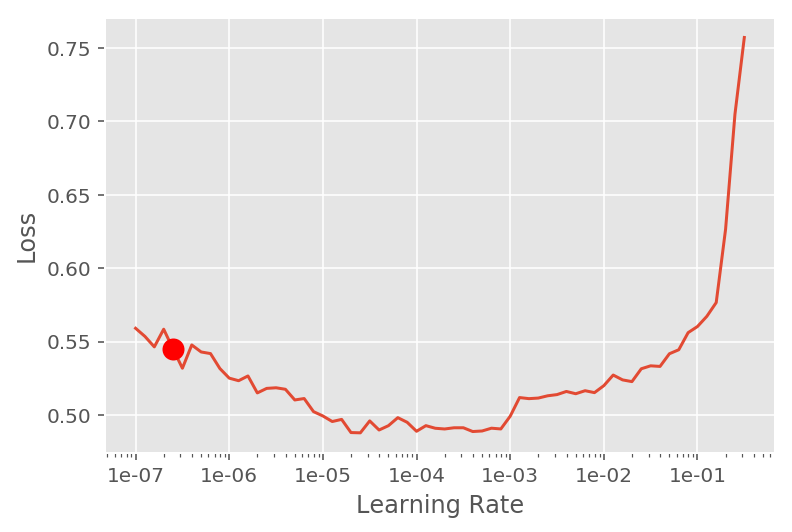

In [34]:
from test_folder import deeplearning

deeplearning.lr_finder_plot(learn)

In [35]:
from fastai.callbacks import SaveModelCallback

learn.fit_one_cycle(3, 5e-6, callbacks=[SaveModelCallback(learn, every='improvement', monitor='auroc', name='best_auroc_resnet'),
                                        EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,auroc,precision,time
0,0.554028,0.490807,0.790486,0.616667,09:24
1,0.497619,0.489687,0.796332,0.616667,09:27
2,0.499311,0.486048,0.791106,0.622642,09:22


Better model found at epoch 0 with auroc value: 0.7904855012893677.
Better model found at epoch 1 with auroc value: 0.7963324189186096.


In [36]:
learn.save('trial25-resnet-rd2')

# _New DenseNet Model_

In [41]:
learn_dense = cnn_learner(data=data, base_arch=models.densenet121, metrics=[AUROC(), Precision()],
                          pretrained=True, ps=0.5, bn_final=True)

In [42]:
learn_dense.fit_one_cycle(5, callbacks=[SaveModelCallback(learn, every='improvement', monitor='precision', name='best_densenet'),
                                        EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,auroc,precision,time
0,0.570092,0.523497,0.751417,0.561404,08:15
1,0.545192,0.480265,0.803508,0.612245,08:15
2,0.517241,0.463426,0.819809,0.666667,08:17


Better model found at epoch 0 with precision value: 0.6226415038108826.
Epoch 3: early stopping


In [43]:
learn_dense.save('trial25-densenet-rd1')

# _Second Round of Training_

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-07
Min loss divided by 10: 1.00E-08


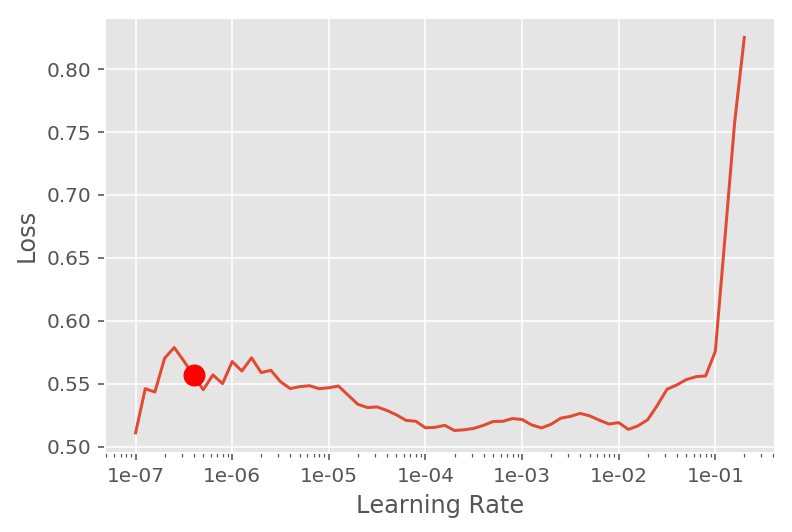

In [47]:
from test_folder import deeplearning

learn_dense.unfreeze()
deeplearning.lr_finder_plot(learn)

In [48]:
learn_dense.load('trial25-densenet-rd1');

In [49]:
learn_dense.fit_one_cycle(3, slice(3e-5), 
                          callbacks=[SaveModelCallback(learn_dense, every='improvement', monitor='precision', name='best_densenet')])

epoch,train_loss,valid_loss,auroc,precision,time
0,0.506365,0.474863,0.812013,0.637931,10:12
1,0.477765,0.468619,0.813342,0.642857,10:09
2,0.497396,0.466201,0.813253,0.645833,10:12


In [50]:
learn_dense.save('trial25-densenet-rd2')